# Polynomial Transport Maps for Variational Inference using KSD

In [143]:
import matplotlib.pyplot as plt
import sklearn.datasets as datasets
import numpy as np

import torch
from torch import nn
from torch import optim
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.distributions.uniform import Uniform
from torch.distributions.normal import Normal

from nflows.flows.base import Flow
from nflows.distributions.normal import StandardNormal
from nflows.transforms.base import CompositeTransform
from nflows.transforms.linear import Linear
from nflows.transforms.linear import NaiveLinear

from nflows.transforms.autoregressive import MaskedAffineAutoregressiveTransform
from nflows.transforms.permutations import ReversePermutation

from nflows.transforms.autoregressive import MaskedPiecewiseCubicAutoregressiveTransform
from nflows.transforms.nonlinearities import Sigmoid
from nflows.transforms.nonlinearities import Logit

import scipy.special

plt.rcParams['figure.figsize'] = [12,12]

## Introduction

This notebook introduces a triangular polynomial transport map for variational inference using the kernelised Stein discrepancy (KSD). Polynomial transports are covered in https://arxiv.org/pdf/1602.05023.pdf, where the Kullback Leibler divergence for variational inference.

The examples in this notebook will be applied to a random vector $\boldsymbol{x} \in \mathbb{R}^2$. In this instance, the polynomial transport map $T: \mathbb{R}^2 \rightarrow \mathbb{R}^2$ is such that

$$
    T (\boldsymbol{x}) = \begin{bmatrix}
        T^1 (x_1) \\
        T^2 (x_1, x_2)
    \end{bmatrix}.
$$

Here, we use a polynomial representation for $T$, which is outlined in Section 5.1 of the aforementioned article. The polynomial representation is parameterised by a coefficient vector $\boldsymbol{\theta}$, which can be optimised via gradient descent methods.

Below, we introduce the polynomial transport map with arbitrary order:

In [144]:
def theta_init(order):
    
    theta_1 = torch.zeros(order + 1)
    theta_1[1] = 1.
    
    n = order + 1.
    r = 2
    numer = torch.from_numpy(np.arange(1,(n + r))).prod()
    denom = torch.from_numpy(np.arange(1,(n + r - 2))).prod()*torch.from_numpy(np.arange(1,3)).prod()
    d_theta_2 = (numer/denom).type(torch.LongTensor)
    theta_2 = torch.zeros(d_theta_2)
    theta_2[1] = 1.
    
    theta = torch.cat([theta_1, theta_2])
    theta.requires_grad=True
    
    return theta

def T_theta(x, theta, order):
    
    N = x.size()[0]
    
    len_theta = len(theta)
    theta = theta.reshape(len_theta, 1)
    
    x_1 = x[:,0].reshape(N, 1)
    x_2 = x[:,1].reshape(N, 1)
    
    X_1 = []
    for i in range(order + 1):
        
        x_1_powers = x_1**i
        X_1.append(x_1_powers)
    
    X_1 = torch.cat(X_1, dim=1)
    
    seq = torch.from_numpy(np.arange(1,(order+1)))
    seq = torch.cat([torch.tensor([0]), seq])
    
    combns = torch.combinations(seq, with_replacement=True)
    n_row = combns.size()[0]
    combns_1 = combns[:,0].reshape(n_row, 1)
    combns_2 = combns[:,1].reshape(n_row, 1)
    combns_rev = torch.cat([combns_2, combns_1], dim=1)
    neq_rows = (combns_1!=combns_2).reshape(n_row)
    combns_rev = combns_rev[neq_rows,:]
    
    combns = torch.cat([combns, combns_rev], dim=0)
    sum_crit = (combns.sum(dim=1) <= order)
    combns = combns[sum_crit,:]
    n_combns = combns.size()[0]
    
    for i in seq:
        
        combns_i = combns[combns[:,0]==i,:]
        sorted_combns_i, _ = torch.sort(combns_i[:,1])
        combns[combns[:,0]==i,1] = sorted_combns_i
    
    combns_array = []
    for i in seq:
    
        sub_tensor = combns[combns[:,0]==i,:]
        combns_array.append(sub_tensor)
    
    combns = torch.cat(combns_array, dim = 0)
    
    X_2 = []
    for i in range(n_combns):
        
        powers = combns[i,:]
        x_1_powers = x_1**(powers[0])
        x_2_powers = x_2**(powers[1])
        mult_vec = x_1_powers*x_2_powers
        X_2.append(mult_vec)
    
    X_2 = torch.cat(X_2, dim=1)
    
    n_col_X_1 = X_1.size()[1]
    n_col_X_2 = X_2.size()[1]
    
    zero_mat_1 = torch.zeros(N, n_col_X_2)
    zero_mat_2 = torch.zeros(N, n_col_X_1)
    X_1 = torch.cat((X_1, zero_mat_1), dim=1)
    X_2 = torch.cat((zero_mat_2, X_2), dim=1)
    
    X = torch.cat((X_1, X_2), dim = 1).reshape(2*N, len_theta)
    
    T_theta_mat = torch.mm(X, theta).reshape(N, 2)
    return T_theta_mat

## Defining KSD loss function

Recall that KSD can be approximated as
$$ \mathbb{S}_P(Q) \approx \frac{1}{n^2} \sum_{i=1}^n\sum_{j=1}^n u_p(x_i,x_j),$$

where $\{x_i\}_{i=1}^n$ is a sample from $Q$ and 

$$ u_p(x,y) = s_p(x)^\top k(x,y) s_p(y) + s_p(x)^\top \nabla_yk(x,y) + \nabla_xk(x,y)s_p(y) + \nabla_x\cdot\nabla_yk(x,y).$$

In our simulations, we will use the multi-quadric kernel, defined by

$$
    k(x, y) \equiv \left\{
        1 + || \Gamma^{-1/2} (x - y) ||^2
    \right\}^{-1/2}.
$$

The KSD is presented as a function below:

In [145]:
l2 = nn.PairwiseDistance(2)

def loss_KSD(samples,score_func):
    N = samples.size()[0]
    d = samples[0].size()[0] #dimension of tensor
        
    scores = score_func(samples)
    s1 = scores.repeat(1,N).view(N*N,2)
    s2 = scores.repeat(N,1)
    
    samps1 = samples.repeat(1,N).view(N*N,2)
    samps2 = samples.repeat(N,1)

    diffs = samps1 - samps2
    dists = l2(samps1,samps2)**2

    k = (1 + dists)**(-1/2)
    k_x = -(1 + dists[:,None])**(-3/2)*diffs
    k_y = -k_x
    k_xy = -3*dists*(1 + dists)**(-5/2) + d*(1 + dists)**(-3/2)
    
    outvec = k*torch.sum(s1*s2,dim=-1) + torch.sum(s1*k_y,dim=-1) + torch.sum(s2*k_x,dim=-1) + k_xy
    output = torch.mean(outvec)
    
    return output

## Distributions Encountered in this Notebook

A flexible parameterisation of densities are Energy Based Models (EBMs), where

$$ p(x) \propto \exp(-E(x)), $$

where $E$ is some energy function (assuming that $\int \exp(-E(x))\,\mathrm{d}x$ is finite). In this case, the score function is of the form

$$ s(x) = -\nabla E(x). $$

### Gaussian Distribution

Suppose $x \sim N(\mu, \Sigma)$. Then, the probability density function of $\boldsymbol{x}$ is

$$
    p(\boldsymbol{x}) =
        \frac{1}{2\pi} |\Sigma|^{-1/2} \exp \left\{
            (\boldsymbol{x} - \mu)^\intercal \Sigma^{-1} (\boldsymbol{x} - \mu)
        \right\},
$$

and the score function is

$$
    s(x) = - \Sigma^{-1} (x - \mu).
$$

Below, we define the score function for the Gaussian distribution.

In [146]:
def score_gaussian(x, mu, Sigma):
    N, d = x.size()
    mu = mu.reshape(1, d)
    Sigma_inv = torch.inverse(Sigma)
    x_centre = (x - mu).t()
    score_mat = torch.mm(-Sigma_inv, x_centre).t()
    return score_mat

Next, we present an example of how to sample and plot the distribution:

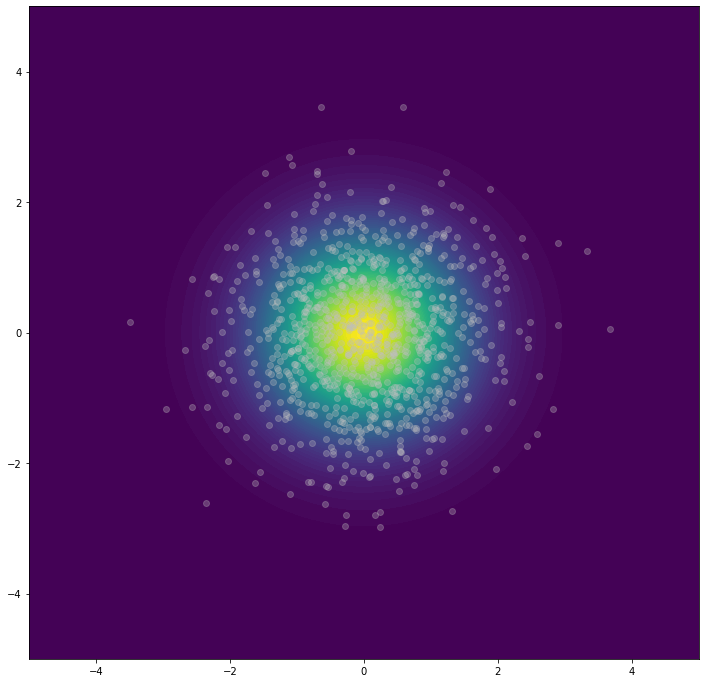

In [147]:
x_lim = torch.tensor([-5, 5])
y_lim = torch.tensor([-5, 5])
mu = torch.zeros(2)
Sigma = torch.eye(2)
n_levs = 100
N = 1000

def plot_gauss(mu, Sigma, x_lim, y_lim, n_levs):
    
    x_min = x_lim[0]
    x_max = x_lim[1]
    
    y_min = y_lim[0]
    y_max = y_lim[1]
    
    x_line = torch.linspace(x_min, x_max)
    y_line = torch.linspace(y_min, y_max)
    
    x_g, y_g = torch.meshgrid(x_line, y_line)
    xy_g = torch.cat([x_g.reshape(-1, 1), y_g.reshape(-1, 1)], dim=1)
    
    with torch.no_grad():
        gauss_dist = MultivariateNormal(mu, Sigma)
        pdf_g = gauss_dist.log_prob(xy_g).exp().reshape(100,100)
    
    plt.contourf(x_g.numpy(), y_g.numpy(), pdf_g.numpy(), levels = n_levs)



def sample_gauss(N, mu, Sigma):
    
    gauss_dist = MultivariateNormal(mu, Sigma)
    gauss_samp = gauss_dist.sample((N,))
    
    return gauss_samp

plot_gauss(mu, Sigma, x_lim, y_lim, n_levs)

gauss_samp = sample_gauss(N, mu, Sigma)
plt.scatter(np.transpose(gauss_samp)[0], np.transpose(gauss_samp)[1], color='silver', alpha=0.3)

### Gaussian Mixture Distribution

Suppose $\boldsymbol{x}$ is distributed as a \emph{Gaussian mixture} with $K$ mixture components. Suppose that the means are $\{ \mu_1, \dots, \mu_K \}$. For simplicity, we will assume that all of the covariance matrices are identity matrices and that the mixture weights are uniform. Then, the probability density function of $\boldsymbol{x}$ is

$$
    p (\boldsymbol{x}) = \frac{1}{K} \sum_{k=1}^K \mathcal{N} (\boldsymbol{x}; \mu, \Sigma),
$$

where $\mathcal{N} (\boldsymbol{x}; \mu, \Sigma)$ is the Gaussian density function with mean $\mu$ and covariance matrix $\Sigma$. The score is such that

$$
    s(x) =
        -\frac{1}{\sum_{k=1}^K \exp \left( || x - \mu_k ||^2 \right)}
        \sum_{k=1}^K \exp \left( || x - \mu_k ||^2 \right) (x - \mu_k)
$$

Below, we will define this score function:

In [170]:
def score_gm(x, mu):
    
    N, d = x.size()
    K = len(mu)
    
    numer_sum = torch.zeros(2, N)
    denom_sum = torch.zeros(N)
    
    for k in range(K):
        
        mu_k = mu[k].reshape(1, d)
        x_centre = x - mu_k
        norm_sq_vec = (x_centre**2).sum(dim=1)
        exp_vec = (-0.5*norm_sq_vec).exp()
        denom_sum = denom_sum + exp_vec
        numer_sum = numer_sum + exp_vec*x_centre.t()
    
    score_mat = (numer_sum/denom_sum).t()
    
    return(score_mat)

Next, we present an example of how to sample and plot the distribution:

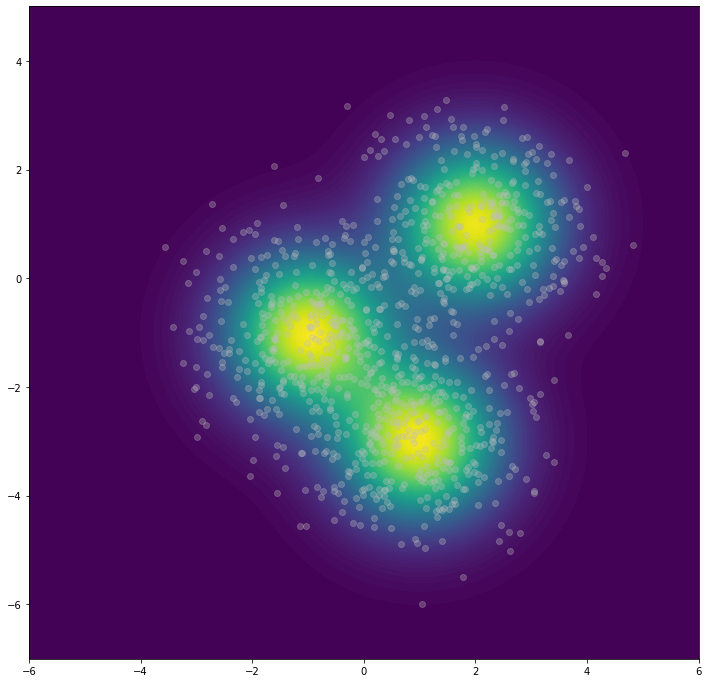

In [149]:
x_lim = torch.tensor([-6, 6])
y_lim = torch.tensor([-7, 5])

mu_1 = torch.tensor([2, 1])
mu_2 = torch.tensor([-1, -1])
mu_3 = torch.tensor([1, -3])
mu_array = torch.empty((3, 2))
mu_array[0] = mu_1
mu_array[1] = mu_2
mu_array[2] = mu_3

N = 1000
n_levs = 100

def plot_gm(mu_array, x_lim, y_lim, n_levs):

    x_min = x_lim[0]
    x_max = x_lim[1]

    y_min = y_lim[0]
    y_max = y_lim[1]

    x_line = torch.linspace(x_min, x_max)
    y_line = torch.linspace(y_min, y_max)

    x_g, y_g = torch.meshgrid(x_line, y_line)
    xy_g = torch.cat([x_g.reshape(-1, 1), y_g.reshape(-1, 1)], dim=1)

    K = mu_array.size()[0]

    with torch.no_grad():

        norm_const = 1/(2*np.pi*K)
        grid_length = xy_g.size()[0]
        sum_val = torch.zeros(grid_length)

        for k in range(K):

            mu_k = mu_array[k]
            gauss_k = MultivariateNormal(mu_k, torch.eye(2))
            pdf_k_g = gauss_k.log_prob(xy_g).exp()
            sum_val = sum_val + pdf_k_g

        pdf_g = (sum_val/K).reshape(100, 100)

    plt.contourf(x_g.numpy(), y_g.numpy(), pdf_g.numpy(), levels=n_levs)

def rand_gm(N, mu_array):

    K = mu_array.size()[0]
    cont_unif = Uniform(torch.tensor([0.]), torch.tensor([K]))
    classes = cont_unif.sample((N,)).floor().type(torch.LongTensor).reshape(N)

    samps = []
    for k in range(K):

        N_k = (classes==k).sum()
        mu_k = mu_array[k]
        gauss_k = MultivariateNormal(mu_k, torch.eye(2))
        gauss_k_sample = gauss_k.sample((N_k,))
        samps.append(gauss_k_sample)

    samps = torch.cat(samps)
    
    return samps

plot_gm(mu_array, x_lim, y_lim, n_levs)
gm_sample = rand_gm(N, mu_array)
plt.scatter(np.transpose(gm_sample)[0], np.transpose(gm_sample)[1], color='silver', alpha=0.3)

### 2D Banana Distribution

The random vector $\boldsymbol{x} = (x_1, x_2)^\intercal$ has a 2D banana distribution with parameters $a, \sigma_1^2 \ \text{and} \ \sigma_2^2$, written

$$
    \boldsymbol{x} \sim \text{Banana} (a, \sigma_1^2, \sigma_2^2)
$$

if the probability density function of $\boldsymbol{x}$ is

$$
    p (\boldsymbol{x}) = \mathcal{N} (x_1; 0, \sigma_1^2) \mathcal{N} (x_2; a x_1^2, \sigma_2^2)
$$

The score function is such that

$$
    s (\boldsymbol{x}) = \begin{bmatrix}
        s_1 (\boldsymbol{x}) \\
        s_2 (\boldsymbol{x})
    \end{bmatrix},
$$

where

$$
    s_1 (\boldsymbol{x}) = -\frac{1}{\sigma_1^2} x_1 + \frac{2 a}{\sigma_2^2} x_1 (x_2 - a x_1^2) \\
    s_2 (\boldsymbol{x}) = -\frac{1}{\sigma_2^2} (x_2 - a x_1^2).
$$

We define this below:

In [150]:
def score_banana(x, a, sigma_1, sigma_2):
    
    N = x.size()[0]
    sigsq_1 = sigma_1**2
    sigsq_2 = sigma_2**2
    
    x_1 = x[:, 0]
    x_2 = x[:, 1]
    
    s_1 = -x_1/sigsq_1 + (2*a/sigsq_2)*x_1*(x_2 - a*(x_1**2))
    s_2 = -(x_2 - a*(x_1**2))/sigsq_2
    
    score_mat = torch.cat((s_1.reshape(N, 1), s_2.reshape(N, 1)), 1)
    return score_mat

Next, we present an example of how to sample and plot the distribution:

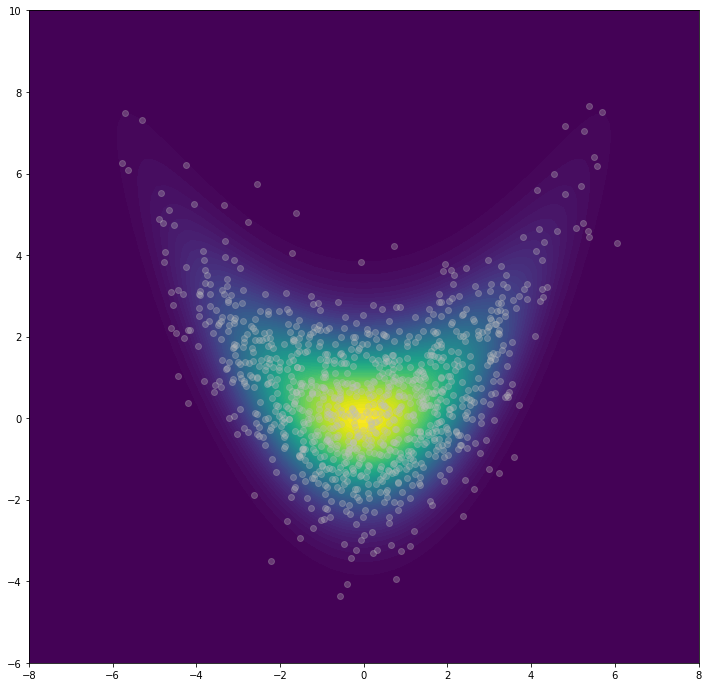

In [154]:
x_lim = torch.tensor([-8, 8])
y_lim = torch.tensor([-6, 10])
a = 0.2
sigma_1 = torch.tensor([2.])
sigma_2 = torch.tensor([1.3])
n_levs = 100
n = 1000

def plot_banana(a, sigma_1, sigma_2, x_lim, y_lim, n_levs):
    
    x_min = x_lim[0]
    x_max = x_lim[1]

    y_min = y_lim[0]
    y_max = y_lim[1]

    x_line = torch.linspace(x_min, x_max)
    y_line = torch.linspace(y_min, y_max)

    x_g, y_g = torch.meshgrid(x_line, y_line)
    xy_g = torch.cat([x_g.reshape(-1, 1), y_g.reshape(-1, 1)], dim=1)

    with torch.no_grad():

        x_coords = xy_g[:,0]
        y_coords = xy_g[:,1]

        gauss_1 = Normal(torch.tensor([0.]), sigma_1)
        pdf_g_1 = gauss_1.log_prob(x_coords).exp()

        mu_2 = a*(x_coords**2)
        gauss_2 = Normal(mu_2, sigma_2)
        pdf_g_2 = gauss_2.log_prob(y_coords).exp()

        pdf_g = (pdf_g_1*pdf_g_2).reshape(100, 100)

    plt.contourf(x_g.numpy(), y_g.numpy(), pdf_g.numpy(), levels = n_levs)

def rand_banana(n, a, sigma_1, sigma_2):
    
    norm_samp_1 = torch.randn(n, 1)
    norm_samp_2 = torch.randn(n, 1)
    x_1 = sigma_1*norm_samp_1
    x_2 = a*(x_1**2) + sigma_2*norm_samp_2
    x = torch.cat((x_1, x_2), 1)
    return x

plot_banana(a, sigma_1, sigma_2, x_lim, y_lim, n_levs)

banana_samp = rand_banana(n, a, sigma_1, sigma_2)
plt.scatter(np.transpose(banana_samp)[0], np.transpose(banana_samp)[1], color='silver', alpha=0.3)

### 2D Sinusoidal Distribution

The random vector $\boldsymbol{x}$ has a 2D sinusoidal distribution with parameters $a, \sigma_1^2 \ \text{and} \ \sigma_2^2$, written

$$
    \boldsymbol{x} \sim \text{Sinusoidal} (a, \sigma_1^2, \sigma_2^2)
$$

if the probability density function of $\boldsymbol{x}$ is


$$
    p(x_1,x_2) = \mathcal{N}(x_1; 0, \sigma_1^2)\mathcal{N}(x_2; \sin(a x_1), \sigma_2^2).
$$

The score function is such that

$$
    s (\boldsymbol{x}) = \begin{bmatrix}
        s_1 (\boldsymbol{x}) \\
        s_2 (\boldsymbol{x})
    \end{bmatrix}
$$

where

$$
    s_1 (\boldsymbol{x}) =
        -\frac{1}{\sigma_1^2} x_1 + \frac{a}{\sigma_2^2} \left\{ x_2 - \sin (a x_1) \right\} \cos (a x_1) \\
    s_2 (\boldsymbol{x}) =
        -\frac{1}{\sigma_2^2} \left\{ x_2 - \sin (a x_1) \right\}
$$

We define this below:

In [152]:
def score_sin(x, a, sigma_1, sigma_2):

    N = x.size()[0]
    sigsq_1 = sigma_1**2
    sigsq_2 = sigma_2**2

    x_1 = x[:, 0]
    x_2 = x[:, 1]

    sin_a_x_1 = (a*x_1).sin()
    cos_a_x_1 = (a*x_1).cos()
    s_1 = -x_1/sigsq_1 + (a/sigsq_2)*(x_2 - sin_a_x_1)*cos_a_x_1
    s_2 = -(x_2 - sin_a_x_1)/sigsq_2

    score_mat = torch.cat((s_1.reshape(N, 1), s_2.reshape(N, 1)), 1)
    return score_mat

Next, we present an example of how to sample and plot the distribution:

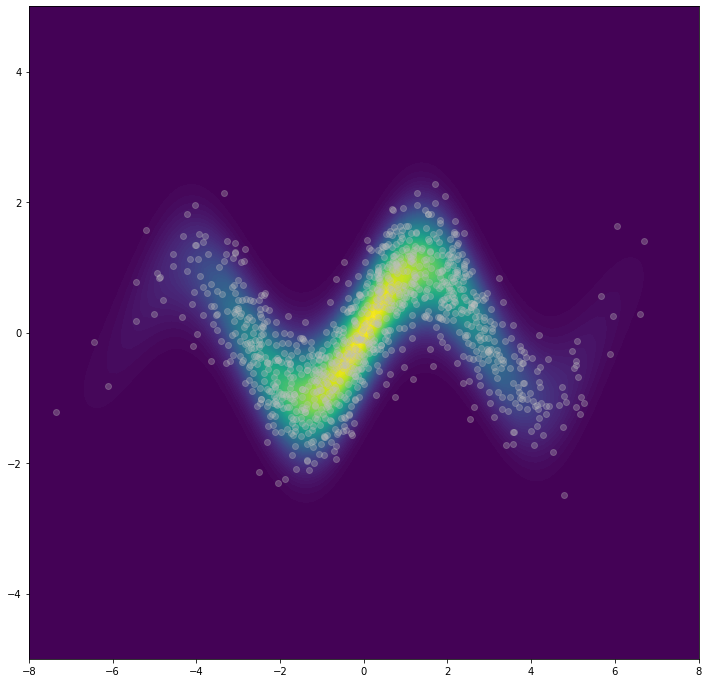

In [153]:
x_lim = torch.tensor([-8, 8])
y_lim = torch.tensor([-5, 5])
n_levs = 100
N = 1000

a = 1.1
sigma_1 = 5**(0.5)
sigma_2 = 0.3**(0.5)

def plot_sin_dist(a, sigma_1, sigma_2, x_lim, y_lim, n_levs):

    x_min = x_lim[0]
    x_max = x_lim[1]

    y_min = y_lim[0]
    y_max = y_lim[1]

    x_line = torch.linspace(x_min, x_max)
    y_line = torch.linspace(y_min, y_max)

    x_g, y_g = torch.meshgrid(x_line, y_line)
    xy_g = torch.cat([x_g.reshape(-1, 1), y_g.reshape(-1, 1)], dim=1)

    with torch.no_grad():

        x_coords = xy_g[:,0]
        y_coords = xy_g[:,1]

        gauss_1 = Normal(torch.tensor([0.]), sigma_1)
        pdf_1 = gauss_1.log_prob(x_coords).exp()

        mu_2 = (a*x_coords).sin()
        gauss_2 = Normal(mu_2, sigma_2)
        pdf_2 = gauss_2.log_prob(y_coords).exp()

        pdf_g = (pdf_1*pdf_2).reshape(100, 100)


    plt.contourf(x_g.numpy(), y_g.numpy(), pdf_g.numpy(), levels = n_levs)

def rand_sin(N, a, sigma_1, sigma_2):
    
    samp_1 = torch.randn(N)
    samp_2 = torch.randn(N)

    norm_1_samp = sigma_1*samp_1
    norm_1_samp = norm_1_samp.reshape(N, 1)

    mu_2 = (a*norm_1_samp).sin()
    norm_2_samp = sigma_2*samp_2.reshape(N, 1) + mu_2

    sin_samp = torch.cat([norm_1_samp, norm_2_samp], dim=1)
    
    return sin_samp

plot_sin_dist(a, sigma_1, sigma_2, x_lim, y_lim, n_levs)
sin_samp = rand_sin(N, a, sigma_1, sigma_2)
plt.scatter(np.transpose(sin_samp)[0], np.transpose(sin_samp)[1], color='silver', alpha=0.3)

## Simulations

Here, we will conduct variational inference with the KSD using stochastic gradient descent.

### Base Distribution

The base distribution for all simulations will be a $\mathcal{N} (\textbf{0}, \textbf{I})$:

In [156]:
mu_Q = torch.zeros(2)
Sigma_Q = torch.eye(2)
base_dist = MultivariateNormal(mu_Q, Sigma_Q)

## Transport to a Gaussian

Let's start with an arbitrary $\mathcal{N} (\mu, \Sigma)$ target. In this instance, a linear transport map will be sufficient.

In [159]:
# Set the target:
mu_P = torch.tensor([3., -4.])
Sigma_P = torch.tensor([[2., -0.5],[-0.5, 1.5]])

# Set the score function:
gaussian_score = lambda x: score_gaussian(x, mu_P, Sigma_P)

# Set the algorithm parameters:
n_iter = 10000
N = 100
poly_order = 1

# Initialise theta:

theta = theta_init(poly_order)

# Establish the optimizer:

optimizer = optim.Adam([theta])

# Run the SGD algorithm:

for i in range(n_iter):
    
    # random sample:
    x = base_dist.sample((N,))

    # transport:
    T_x = T_theta(x, theta, poly_order)

    # loss:
    loss = loss_KSD(T_x, gaussian_score)

    # gradient:
    loss.backward()

    # SGD step:
    optimizer.step()

    # zero gradients:
    optimizer.zero_grad()
    
    if (i + 1) % 500 == 0:
        print("iteration: " + str(i+1) + ", loss: " + str(loss.item()))

iteration: 500, loss: 2.3589060306549072
iteration: 1000, loss: 1.4852769374847412
iteration: 1500, loss: 1.1898266077041626
iteration: 2000, loss: 0.8948803544044495
iteration: 2500, loss: 0.521783709526062
iteration: 3000, loss: 0.6598362326622009
iteration: 3500, loss: 0.4331732988357544
iteration: 4000, loss: 0.1899259090423584
iteration: 4500, loss: 0.1344299167394638
iteration: 5000, loss: 0.10279790312051773
iteration: 5500, loss: 0.06722831726074219
iteration: 6000, loss: 0.04616221785545349
iteration: 6500, loss: 0.04540775716304779
iteration: 7000, loss: 0.03871561586856842
iteration: 7500, loss: 0.02595822513103485
iteration: 8000, loss: 0.017789727076888084
iteration: 8500, loss: 0.03459306061267853
iteration: 9000, loss: 0.02419462986290455
iteration: 9500, loss: 0.02535085380077362
iteration: 10000, loss: 0.03439369797706604


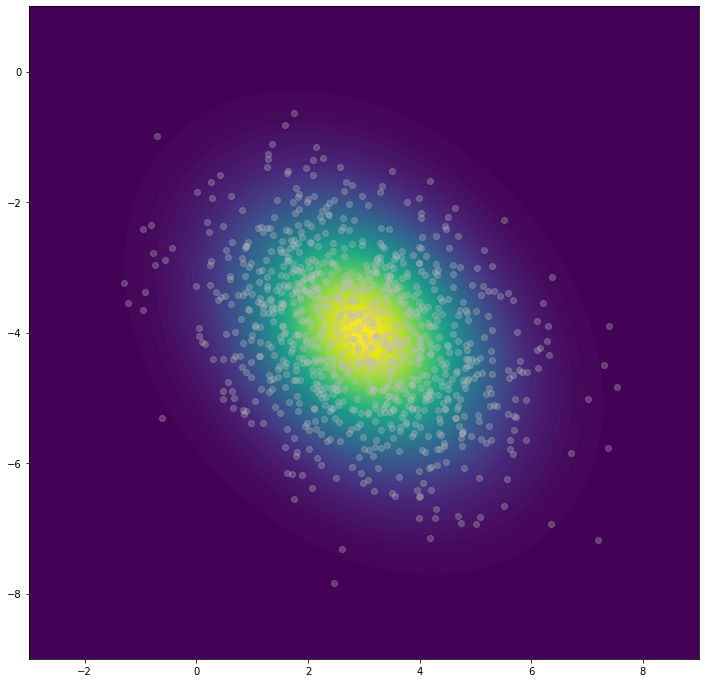

In [167]:
N = 1000

Q_sample = base_dist.sample((N,))
T_Q_sample = T_theta(Q_sample, theta, poly_order)
T_Q_sample = T_Q_sample.detach().numpy()

x_lim = torch.tensor([-3, 9])
y_lim = torch.tensor([-9, 1])
n_levs = 100
N = 1000

plot_gauss(mu_P, Sigma_P, x_lim, y_lim, n_levs)
plt.scatter(np.transpose(T_Q_sample)[0], np.transpose(T_Q_sample)[1], color='silver', alpha=0.3)

The results are good, but this is an easy example.

## Transport to a Normal Mixture

In this instance, a quadratic transport map may be sufficient.

In [172]:
# Set the target:
mu_1 = torch.Tensor([[2, 2]])
mu_2 = torch.Tensor([[-2, -2]])
mu_P = torch.cat([mu_1, mu_2])

# Set the score function:
gm_score = lambda x: score_gm(x, mu_P)

# Set the algorithm parameters:
n_iter = 10000
N = 100
poly_order = 2

# Initialise theta:

theta = theta_init(poly_order)

# Establish the optimizer:

optimizer = optim.Adam([theta])

# Run the SGD algorithm:

for i in range(n_iter):
    
    # random sample:
    x = base_dist.sample((N,))

    # transport:
    T_x = T_theta(x, theta, poly_order)

    # loss:
    loss = loss_KSD(T_x, gm_score)

    # gradient:
    loss.backward()

    # SGD step:
    optimizer.step()

    # zero gradients:
    optimizer.zero_grad()
    
    if (i + 1) % 500 == 0:
        print("iteration: " + str(i+1) + ", loss: " + str(loss.item()))

iteration: 500, loss: 0.35841450095176697
iteration: 1000, loss: 0.309310644865036
iteration: 1500, loss: 0.32777759432792664
iteration: 2000, loss: 0.29320967197418213
iteration: 2500, loss: 0.3158818483352661
iteration: 3000, loss: 0.2916671931743622
iteration: 3500, loss: 0.25726941227912903
iteration: 4000, loss: 0.3032252788543701
iteration: 4500, loss: 0.3279741108417511
iteration: 5000, loss: 0.27233007550239563
iteration: 5500, loss: 0.2755671739578247
iteration: 6000, loss: 0.28482699394226074
iteration: 6500, loss: 0.2502819299697876
iteration: 7000, loss: 0.3049106299877167
iteration: 7500, loss: 0.256855309009552
iteration: 8000, loss: 0.24449296295642853
iteration: 8500, loss: 0.26281076669692993
iteration: 9000, loss: 0.31724271178245544
iteration: 9500, loss: 0.2918815016746521
iteration: 10000, loss: 0.3156951665878296


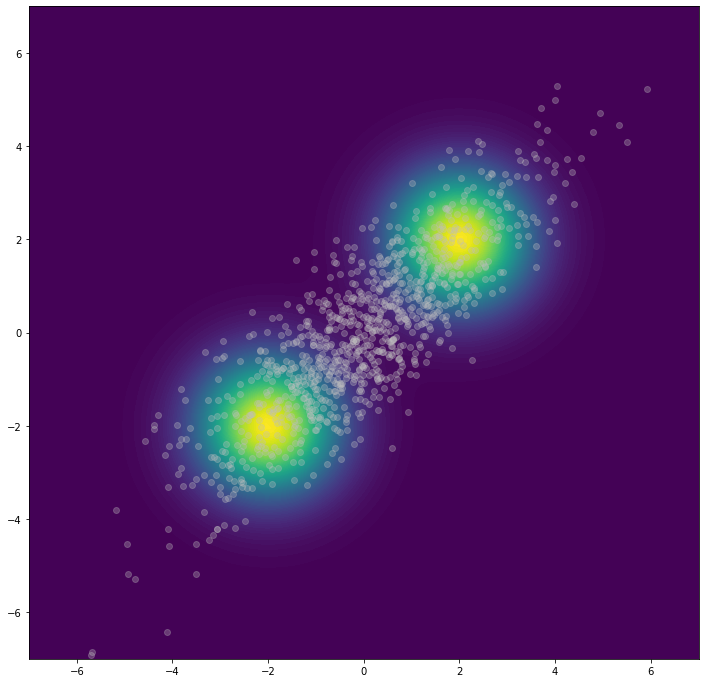

In [174]:
N = 1000

Q_sample = base_dist.sample((N,))
T_Q_sample = T_theta(Q_sample, theta, poly_order)
T_Q_sample = T_Q_sample.detach().numpy()

x_lim = torch.tensor([-7, 7])
y_lim = torch.tensor([-7, 7])
n_levs = 100
N = 1000

plot_gm(mu_P, x_lim, y_lim, n_levs)
plt.scatter(np.transpose(T_Q_sample)[0], np.transpose(T_Q_sample)[1], color='silver', alpha=0.3)

It seems that variational inference on multimodal distributions may be a bit tricky!

## Transport to a Normal Mixture

Again, a quadratic transport map should be sufficient.

In [175]:
# Set the target:
a = 0.2
sigma_1 = 2
sigma_2 = 1.3

# Set the score function:
banana_score = lambda x: score_banana(x, a, sigma_1, sigma_2)

# Set the algorithm parameters:
n_iter = 10000
N = 100
poly_order = 2

# Initialise theta:

theta = theta_init(poly_order)

# Establish the optimizer:

optimizer = optim.Adam([theta])

# Run the SGD algorithm:

for i in range(n_iter):
    
    # random sample:
    x = base_dist.sample((N,))

    # transport:
    T_x = T_theta(x, theta, poly_order)

    # loss:
    loss = loss_KSD(T_x, banana_score)

    # gradient:
    loss.backward()

    # SGD step:
    optimizer.step()

    # zero gradients:
    optimizer.zero_grad()
    
    if (i + 1) % 500 == 0:
        print("iteration: " + str(i+1) + ", loss: " + str(loss.item()))

iteration: 500, loss: 0.033979859203100204
iteration: 1000, loss: 0.031446851789951324
iteration: 1500, loss: 0.0227903313934803
iteration: 2000, loss: 0.027954459190368652
iteration: 2500, loss: 0.04019845649600029
iteration: 3000, loss: 0.032266199588775635
iteration: 3500, loss: 0.03805585205554962
iteration: 4000, loss: 0.016535015776753426
iteration: 4500, loss: 0.024592403322458267
iteration: 5000, loss: 0.03423411399126053
iteration: 5500, loss: 0.025037169456481934
iteration: 6000, loss: 0.033098094165325165
iteration: 6500, loss: 0.03417617827653885
iteration: 7000, loss: 0.030490677803754807
iteration: 7500, loss: 0.028338292613625526
iteration: 8000, loss: 0.024524737149477005
iteration: 8500, loss: 0.033475108444690704
iteration: 9000, loss: 0.031495559960603714
iteration: 9500, loss: 0.026480065658688545
iteration: 10000, loss: 0.032538555562496185


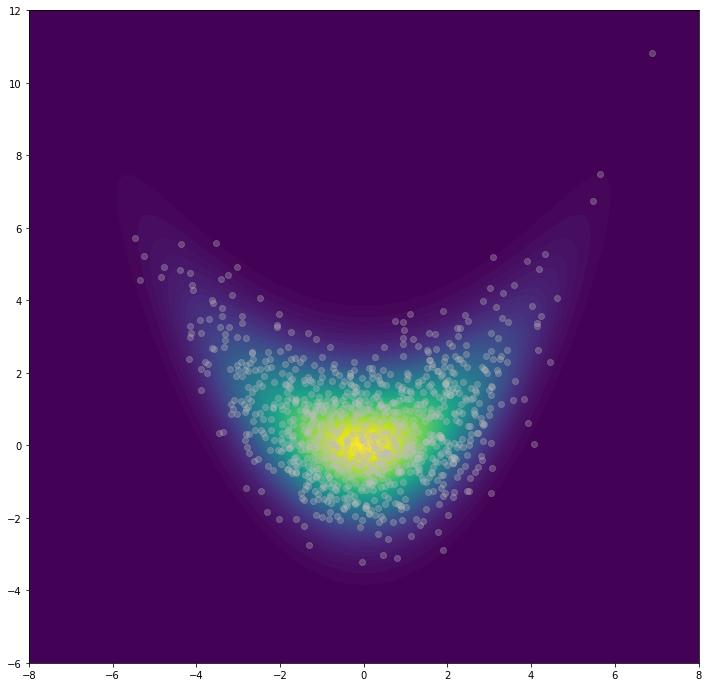

In [177]:
N = 1000

Q_sample = base_dist.sample((N,))
T_Q_sample = T_theta(Q_sample, theta, poly_order)
T_Q_sample = T_Q_sample.detach().numpy()

x_lim = torch.tensor([-8, 8])
y_lim = torch.tensor([-6, 12])
n_levs = 100
N = 1000

plot_banana(a, sigma_1, sigma_2, x_lim, y_lim, n_levs)
plt.scatter(np.transpose(T_Q_sample)[0], np.transpose(T_Q_sample)[1], color='silver', alpha=0.3)

## Transport to a Sinusoidal Mixture

This time, a cubic map will be necessary

In [179]:
# Set the target:
a = 1.1
sigma_1 = 2**(0.5)
sigma_2 = 0.3**(0.5)

# Set the score function:
sin_score = lambda x: score_sin(x, a, sigma_1, sigma_2)

# Set the algorithm parameters:
n_iter = 10000
N = 100
poly_order = 3

# Initialise theta:

theta = theta_init(poly_order)

# Establish the optimizer:

optimizer = optim.Adam([theta])

# Run the SGD algorithm:

for i in range(n_iter):
    
    # random sample:
    x = base_dist.sample((N,))

    # transport:
    T_x = T_theta(x, theta, poly_order)

    # loss:
    loss = loss_KSD(T_x, sin_score)

    # gradient:
    loss.backward()

    # SGD step:
    optimizer.step()

    # zero gradients:
    optimizer.zero_grad()
    
    if (i + 1) % 500 == 0:
        print("iteration: " + str(i+1) + ", loss: " + str(loss.item()))

iteration: 500, loss: 0.15632660686969757
iteration: 1000, loss: 0.21117712557315826
iteration: 1500, loss: 0.11285354942083359
iteration: 2000, loss: 0.16918085515499115
iteration: 2500, loss: 0.059592217206954956
iteration: 3000, loss: 0.14762789011001587
iteration: 3500, loss: 0.151723712682724
iteration: 4000, loss: 0.09007144719362259
iteration: 4500, loss: 0.08116264641284943
iteration: 5000, loss: 0.08716878294944763
iteration: 5500, loss: 0.035101957619190216
iteration: 6000, loss: 0.0602029524743557
iteration: 6500, loss: 0.06376870721578598
iteration: 7000, loss: 0.05703699216246605
iteration: 7500, loss: 0.050277043133974075
iteration: 8000, loss: 0.10647334158420563
iteration: 8500, loss: 0.054650116711854935
iteration: 9000, loss: 0.08519434928894043
iteration: 9500, loss: 0.05186447128653526
iteration: 10000, loss: 0.08913811296224594


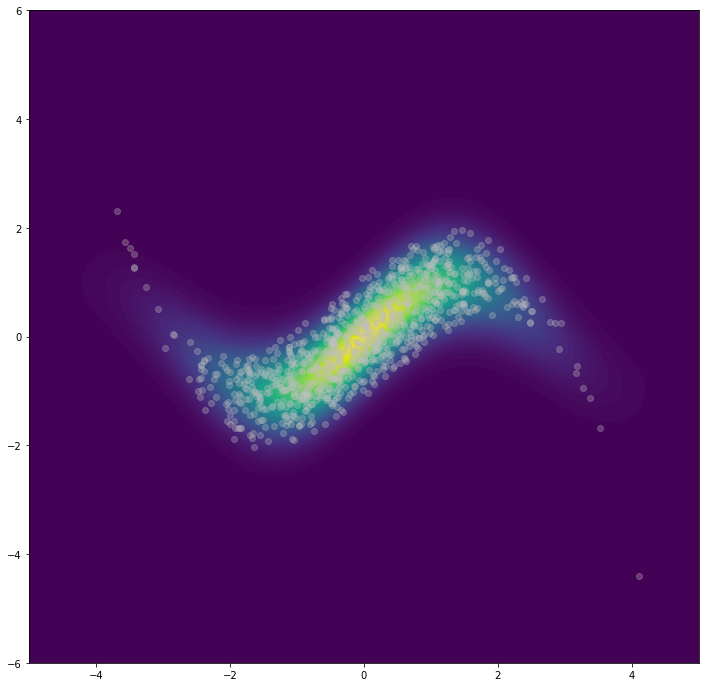

In [183]:
N = 1000

Q_sample = base_dist.sample((N,))
T_Q_sample = T_theta(Q_sample, theta, poly_order)
T_Q_sample = T_Q_sample.detach().numpy()

x_lim = torch.tensor([-5, 5])
y_lim = torch.tensor([-6, 6])
n_levs = 100
N = 1000

plot_sin_dist(a, sigma_1, sigma_2, x_lim, y_lim, n_levs)
plt.scatter(np.transpose(T_Q_sample)[0], np.transpose(T_Q_sample)[1], color='silver', alpha=0.3)

This seems OK! Let's try a more complicated one:

In [185]:
# Set the target:
a = 1.1
sigma_1 = 5**(0.5)
sigma_2 = 0.3**(0.5)

# Set the score function:
sin_score = lambda x: score_sin(x, a, sigma_1, sigma_2)

# Set the algorithm parameters:
n_iter = 10000
N = 100
poly_order = 5

# Initialise theta:

theta = theta_init(poly_order)

# Establish the optimizer:

optimizer = optim.Adam([theta])

# Run the SGD algorithm:

for i in range(n_iter):
    
    # random sample:
    x = base_dist.sample((N,))

    # transport:
    T_x = T_theta(x, theta, poly_order)

    # loss:
    loss = loss_KSD(T_x, sin_score)

    # gradient:
    loss.backward()

    # SGD step:
    optimizer.step()

    # zero gradients:
    optimizer.zero_grad()
    
    if (i + 1) % 500 == 0:
        print("iteration: " + str(i+1) + ", loss: " + str(loss.item()))

iteration: 500, loss: 0.12018195539712906
iteration: 1000, loss: 0.46620914340019226
iteration: 1500, loss: 0.09646538645029068
iteration: 2000, loss: 0.24408261477947235
iteration: 2500, loss: 0.2002926617860794
iteration: 3000, loss: 0.10704229772090912
iteration: 3500, loss: 0.20532871782779694
iteration: 4000, loss: 0.11918189376592636
iteration: 4500, loss: 0.08253590762615204
iteration: 5000, loss: 0.11734488606452942
iteration: 5500, loss: 0.07107587903738022
iteration: 6000, loss: 0.10061904042959213
iteration: 6500, loss: 0.09109766036272049
iteration: 7000, loss: 0.12180981785058975
iteration: 7500, loss: 0.0644461140036583
iteration: 8000, loss: 0.09512276947498322
iteration: 8500, loss: 0.0505509115755558
iteration: 9000, loss: 0.041875727474689484
iteration: 9500, loss: 0.06688562780618668
iteration: 10000, loss: 0.06597209721803665


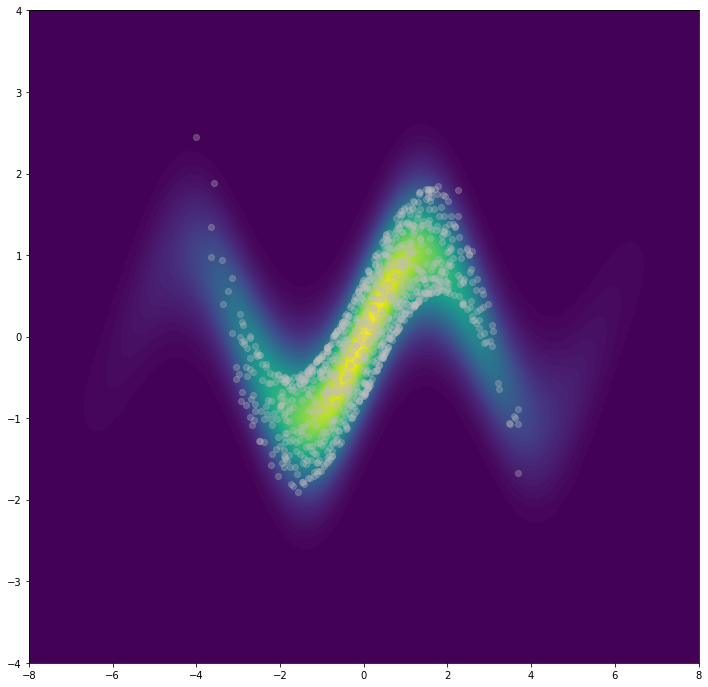

In [188]:
N = 1000

Q_sample = base_dist.sample((N,))
T_Q_sample = T_theta(Q_sample, theta, poly_order)
T_Q_sample = T_Q_sample.detach().numpy()

x_lim = torch.tensor([-8, 8])
y_lim = torch.tensor([-4, 4])
n_levs = 100
N = 1000

plot_sin_dist(a, sigma_1, sigma_2, x_lim, y_lim, n_levs)
plt.scatter(np.transpose(T_Q_sample)[0], np.transpose(T_Q_sample)[1], color='silver', alpha=0.3)

It seems to struggle to find the tails ...